### Jeremy Kazimer
#### 5018-1732
#### Assignment #4

---

As always, the import statements should be at the top of the code!

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time

In this part of the assignment, we can recreate the previous assignment, that is to say the wave function, but this time by solving it via TensorFlow.  The equations are still the same, but now we must adjust all of our inputs such that they follow the TensorFlow formula.  Namely,

In [2]:
def make_kernel(a):
    
    """Transform a 2D array into a convolution kernel"""
    
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1,1])
    
    return tf.constant(a, dtype=1)

def simple_conv(x, k):
    
    """A simplified 2D convolution operation"""
    
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
    
    return y[0, :, :, 0]

where this code comes from the CompPhys repository [here](https://github.com/ubsuny/CompPhys/blob/PDEupdate/PDEs/CNN-PDE.ipynb).  All code from this point on will as well, unless otherwise specified.  We can then apply this to the Laplace and its isotropic equivalent:

In [3]:
def laplace_iso(x):
    
    """Compute the 2D Laplacian of an array"""
    
    laplace_k = make_kernel([[0.25, 0.5, 0.25],
                           [0.5, -3., 0.5],
                           [0.25, 0.5, 0.25]])
    
    return simple_conv(x, laplace_k)

def laplace(x):
    
    """Compute the 2D Laplacian of an array"""
    
    laplace_k = make_kernel([[0., 1., 0.],
                           [1., -4., 1.],
                           [0., 1., 0.]])
    
    return simple_conv(x, laplace_k)

Note that $L$ is fixed here, which is fine.  Since the purpose of this experiment is to more-so observe runtimes, we don't have to vary it.  Now, with the base functions implemented, we can look to the actual TensorFlow implementation!

In [4]:
session = tf.InteractiveSession()
tf.compat.v1.disable_eager_execution()

Eager execution normally means that things are calculated as they come up...this is great for TensorFlow 2.0 and onwards, but not so much 1.14, which is what the Pi Zero W runs on.  As such, we disable it so that it doesn't interfere.  We must also declare our initial conditions from earlier:

In [5]:
N = 500

u_init = np.zeros([N, N], dtype = np.float32)
ut_init = np.zeros([N, N], dtype = np.float32)

u_init[N//2, N//2] = 10

And now we can create TensorFlow variables! These act very similarly to SymPy, but with far more shorthand.

In [6]:
'''
    eps -> a constant.  In perturbation theory, this is the perturbation parameter.  It applies here as well,
    since it determines how much the original equation is offset by the delta.
    
    damping -> a constant, representing the system damping.  This prevents the system from growing much faster.
    
    c -> This is the speed of light, but for a toy model it's rather arbitrary.
'''

eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())
c = tf.placeholder(tf.float32, shape=())

U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

We can now create our equivalent functions, from earlier:

In [7]:
U_ = U + eps * Ut
Ut_ = Ut + eps * ((c ** 2) * laplace(U) - damping * Ut)

In [8]:
step = tf.group(
    U.assign(U_),
    Ut.assign(Ut_))

In [9]:
tf.global_variables_initializer().run()

Note that the `tf.group()` functions forces both values `U` and `Ut` to be updated at the same time.  We can now run this for $1000$ steps, and time each iteration:

In [10]:
nsteps = 1000
ts = np.zeros((nsteps))

for n in range(nsteps):
    t0 = time.time()
    
    step.run({eps: 0.03, damping: 0.04, c: 3.0})
    
    t1 = time.time()
    ts[n] = t1 - t0
    print('{:.2f}% done!'.format(100*(n + 1)/nsteps), '\r', end = '')

And a plot:

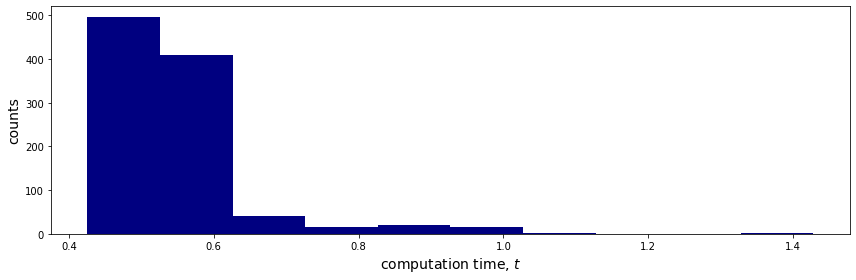

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (12, 4))

ax.hist(ts, 10, color = 'navy')

ax.set_ylabel('counts', fontsize = 14)
ax.set_xlabel('computation time, $t$', fontsize = 14)

fig.tight_layout()

In [12]:
t_avg = np.average(ts)
t_err = np.std(ts)/np.sqrt(nsteps)

In [13]:
print('average runtime per iteration: {:.5f} pm {:.5f} seconds'.format(t_avg, t_err))

average runtime per iteration: 0.54281 pm 0.00322 seconds


Really, besides the actual variable updating, the main computational contribution comes from re-calculating the convolution at each step since matrix multiplication is not an inexpensive process.  I know that NumPy has it down to nearly $\mathcal{O}(N^3)$, but that's still horrendous.  It is that `nn.depthwise_conv2d()` function that is taking all of the time.  

Otherwise, the original Notebook had a lot of display utilities.  Creating a graph is not an expensive process, and one that updates no less:

In [14]:
t0 = time.time()

fig, ax = plt.subplots(1, 1, figsize = (12, 4))

ax.hist(ts, 10, color = 'navy')

ax.set_ylabel('counts', fontsize = 14)
ax.set_xlabel('computation time, $t$', fontsize = 14)

fig.tight_layout()
plt.close()

t1 = time.time()

Without expending the Pi's resources, we can just look at one case and see that...

In [15]:
print('plotting time: {:.5f} seconds'.format(t1 - t0))

plotting time: 2.61495 seconds


This is 4-5 times as long as doing the actual computation per iteration...interesting.  Of course, more practically you would plot the end behavior, so you wouldn't be making, well, 1000 plots.  But for demonstrative purposes, that is a lot of graphs being made.  Since the runtime for each should be practically the same since no conditions are changing, this would be

In [16]:
print('plotting time: {:.5f} seconds'.format(nsteps*(t1 - t0)))

plotting time: 2614.95256 seconds


So, by removing the active display I actually saved myself a bit of time! Perhaps doing `expand_dims()` twice will contribute to the runtime significantly as well, since this is expanding a two dimensional array, twice.  Note that extending a 2D array at its worse time case will be $\mathcal{O}(N^2)$, as [defined here](https://www.geeksforgeeks.org/append-extend-python/) for a 1-D array, which is still not as worse as the matrix multiplication.  Either way, the Pi Zero W is still terrible.

---